# Importing Packages

In [1]:
import pandas as pd
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import mplsoccer
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from getCarries import getCarries
import scipy
from scipy.spatial import ConvexHull
from scipy import stats
from sklearn import preprocessing
from matplotlib.colors import LinearSegmentedColormap
from GridHeatMap import plotGridHeatMap

# Data Prep

In [2]:
events_df = pd.read_csv(r'...\FC Barcelona 20-21.csv',low_memory=False)

In [3]:
pd.set_option('display.max_rows',150)
pd.set_option('display.max_columns',150)

In [4]:
# carries = getCarries(events_df,65) 

# events_df = events_df.append(carries, ignore_index=True)

# events_df.to_csv(r'D:\Analytics\Football\Trials\Data\WhoScored\Barcelona\20-21\FC Barcelona 20-21.csv',index=False)

In [5]:
events_df['recipient'] = events_df['playerId'].shift(-1)
events_df['recipientName'] = events_df['playerName'].shift(-1)

In [6]:
pedriData = events_df[(events_df['playerId']==402197)]

In [7]:
carriesPedri = events_df[(events_df['playerId']==402197)&(events_df['type']=='Carry')]
passesPedri = events_df[(events_df['playerId']==402197)&(events_df['type']=='Pass')&(events_df['outcomeType']=='Successful')]

In [8]:
def isProgressivePass(x,y,endX,endY):
    x = x*1.05
    y = y*0.68
    endX = endX*1.05
    endY = endY*0.68
    
    initDistanceFromGoal = np.sqrt(np.square(105-x)+np.square(34-y))
    finalDistanceFromGoal = np.sqrt(np.square(105-endX)+np.square(34-endY))
    
    
    if (x<=52.5 and endX<=52.5):
        if initDistanceFromGoal - finalDistanceFromGoal > 30:
            return True
    elif (x<=52.5 and endX>52.5):
        if initDistanceFromGoal - finalDistanceFromGoal > 15:
            return True
    elif (x>52.5 and endX>52.5):
        if initDistanceFromGoal - finalDistanceFromGoal > 10:
            return True
    return False

In [9]:
def isProgressiveCarry(x,y,endX,endY):
    x = x*1.05
    y = y*0.68
    endX = endX*1.05
    endY = endY*0.68
    
    
    
    initDistanceFromGoal = np.sqrt(np.square(105-x)+np.square(34-y))
    finalDistanceFromGoal = np.sqrt(np.square(105-endX)+np.square(34-endY))
    
    
    if x > 40*1.05:
        if initDistanceFromGoal - finalDistanceFromGoal > 5:
            return True
    return False

In [10]:
passesPedri['Progressive'] = passesPedri.apply(lambda row: isProgressivePass(row['x'],row['y'],row['endX'],row['endY']),axis=1)
progPasses = passesPedri[passesPedri['Progressive']==True]

In [11]:
carriesPedri['Progressive'] = carriesPedri.apply(lambda row: isProgressiveCarry(row['x'],row['y'],row['endX'],row['endY']),axis=1)
progCarries = carriesPedri[carriesPedri['Progressive']==True]

In [12]:
def isDeepCompletion(endX,endY):
    endX =  endX*1.2
    endY = endY*0.8
    finalDistanceFromGoal = np.sqrt(np.square(120-endX)+np.square(40-endY))
    
    if finalDistanceFromGoal<20:
        return True
    return False

# Deep Completions

In [13]:
pedriDeepComps = pedriData[((pedriData['type']=='Pass')&(pedriData['outcomeType']=='Successful'))|(pedriData['type']=='Carry')]
pedriDeepComps['DeepCompletion'] = pedriDeepComps.apply(lambda row: isDeepCompletion(row['endX'],row['endY']),axis=1)
pedriDeepComps = pedriDeepComps[pedriDeepComps['DeepCompletion']]
pedriDeepComps = pedriDeepComps[pedriDeepComps['passCrossAccurate']!=True]

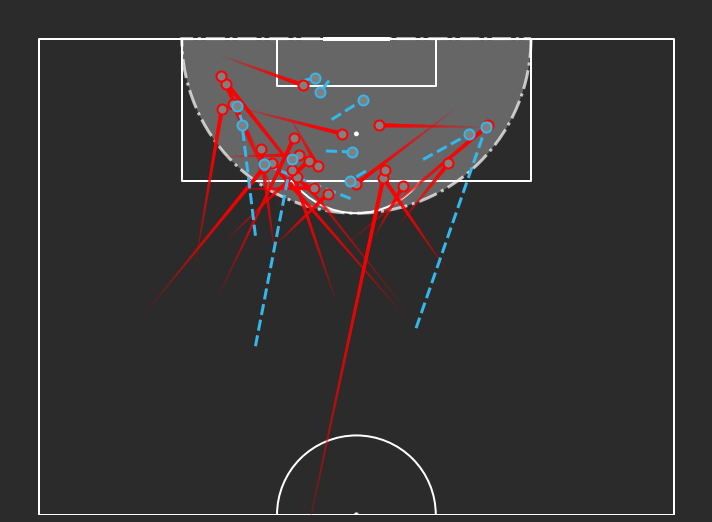

In [14]:
pitch = mplsoccer.VerticalPitch(pitch_type='statsbomb',pitch_color='#2b2b2b',line_color='white', half=True, pad_bottom=0) 
fig, ax = pitch.draw(figsize=(10,15)) 
fig.set_facecolor('#2b2b2b')
# plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

kw1 = {'facecolor':'grey','zorder':0,'linestyle':'-.','edgecolor':'w','linewidth':'3','alpha':0.7}
wedge = mpl.patches.Wedge((40,120),r=22,theta1=180,theta2=0,**kw1)
ax.add_patch(wedge)

lines = pitch.lines(pedriDeepComps[pedriDeepComps['type']=='Pass']['x']*1.2,pedriDeepComps[pedriDeepComps['type']=='Pass']['y']*0.8,
                    pedriDeepComps[pedriDeepComps['type']=='Pass']['endX']*1.2,pedriDeepComps[pedriDeepComps['type']=='Pass']['endY']*0.8,
                    color='r',
                    comet=True,transparent=True,
                    linewidth=4,
                    zorder=2, ax=ax)
lines = pitch.lines(pedriDeepComps[pedriDeepComps['type']=='Carry']['x']*1.2,pedriDeepComps[pedriDeepComps['type']=='Carry']['y']*0.8,
                    pedriDeepComps[pedriDeepComps['type']=='Carry']['endX']*1.2,pedriDeepComps[pedriDeepComps['type']=='Carry']['endY']*0.8,
                    color='#34b7eb',
                    linestyle='dashed',
                    linewidth=3,
                    zorder=2, ax=ax)

nodes = pitch.scatter(pedriDeepComps[pedriDeepComps['type']=='Pass']['endX']*1.2,pedriDeepComps[pedriDeepComps['type']=='Pass']['endY']*0.8,
                      s=100,color='grey',
                      edgecolor='r',linewidth=2,
                      zorder=2, ax=ax)
nodes = pitch.scatter(pedriDeepComps[pedriDeepComps['type']=='Carry']['endX']*1.2,pedriDeepComps[pedriDeepComps['type']=='Carry']['endY']*0.8,
                      s=100,color='grey',
                      edgecolor='#34b7eb',linewidth=2,
                      zorder=2, ax=ax)

# Carries

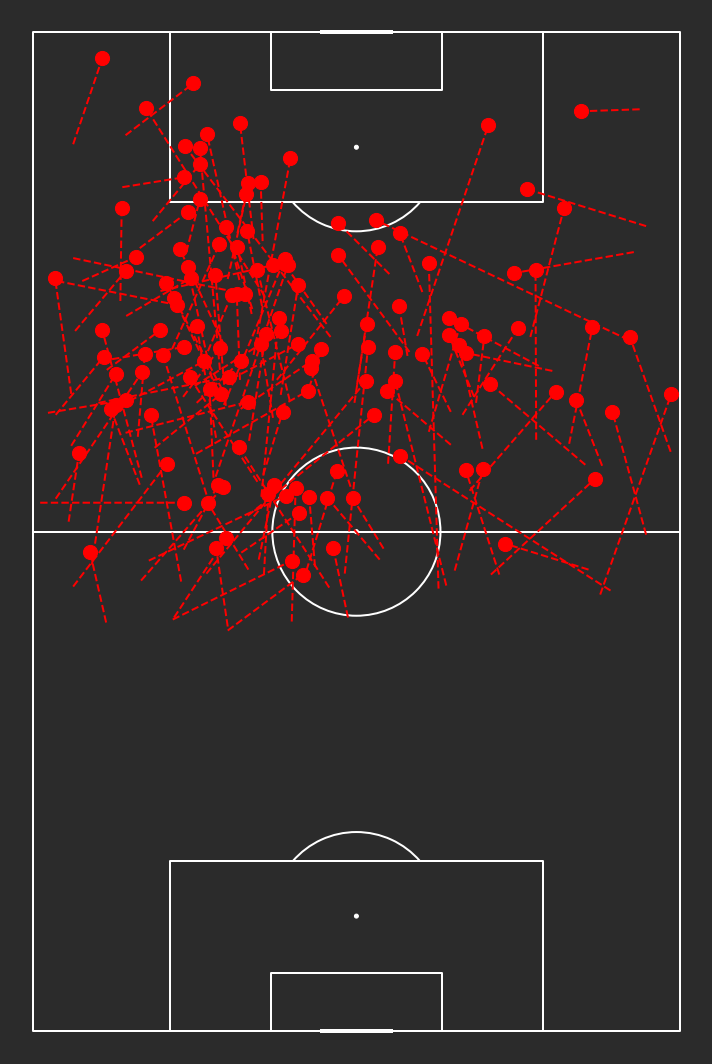

In [18]:
pitch = mplsoccer.VerticalPitch(pitch_type='opta',pitch_color='#2b2b2b',line_color='white') 
fig, ax = pitch.draw(figsize=(10,15)) 
fig.set_facecolor('#2b2b2b')

# lines = pitch.lines(progCarries[progCarries['endX']>=80]['x'],progCarries[progCarries['endX']>=80]['y'],
#                     progCarries[progCarries['endX']>=80]['endX'],progCarries[progCarries['endX']>=80]['endY'],
#                     linestyle='dashed',color='r',linewidth=2,
#                     ax=ax)

# nodes = pitch.scatter(progCarries[progCarries['endX']>=80]['endX'],progCarries[progCarries['endX']>=80]['endY'],
#                       color='r',s=200,ax=ax)

lines = pitch.lines(progCarries['x'],progCarries['y'],
                    progCarries['endX'],progCarries['endY'],
                    linestyle='dashed',color='r',linewidth=2,
                    ax=ax)

nodes = pitch.scatter(progCarries['endX'],progCarries['endY'],
                      color='r',s=200,ax=ax)

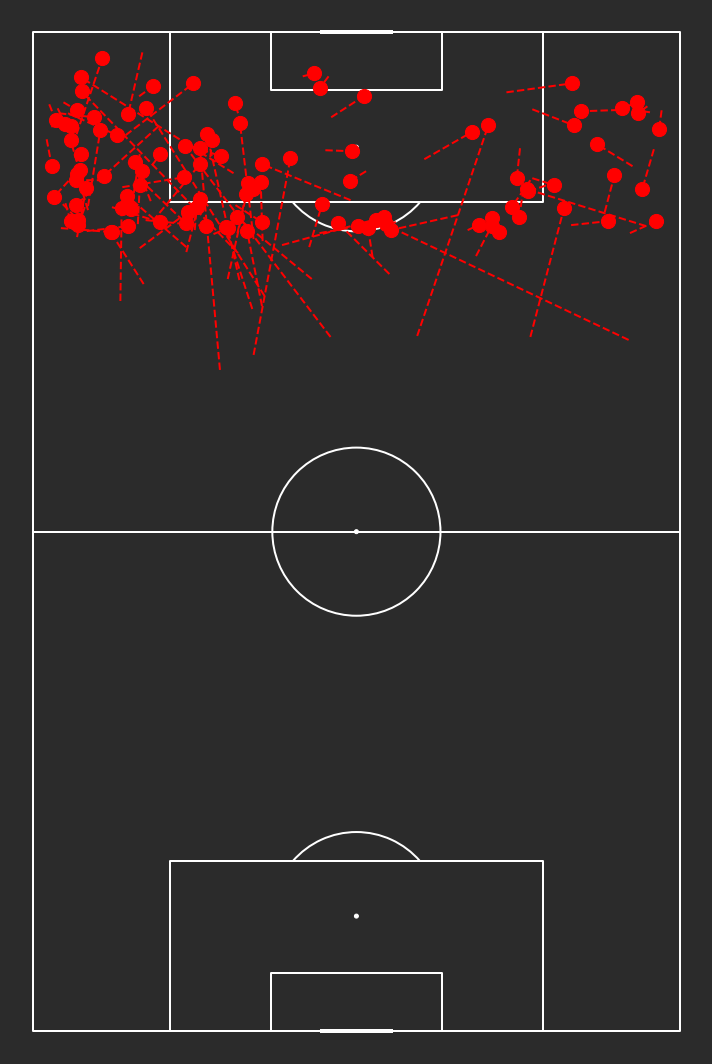

In [19]:
pitch = mplsoccer.VerticalPitch(pitch_type='opta',pitch_color='#2b2b2b',line_color='white') 
fig, ax = pitch.draw(figsize=(10,15)) 
fig.set_facecolor('#2b2b2b')

lines = pitch.lines(carriesPedri[carriesPedri['endX']>=80]['x'],carriesPedri[carriesPedri['endX']>=80]['y'],
                    carriesPedri[carriesPedri['endX']>=80]['endX'],carriesPedri[carriesPedri['endX']>=80]['endY'],
                    linestyle='dashed',color='r',linewidth=2,
                    ax=ax)

nodes = pitch.scatter(carriesPedri[carriesPedri['endX']>=80]['endX'],carriesPedri[carriesPedri['endX']>=80]['endY'],
                      color='r',s=200,ax=ax)

# Positioning

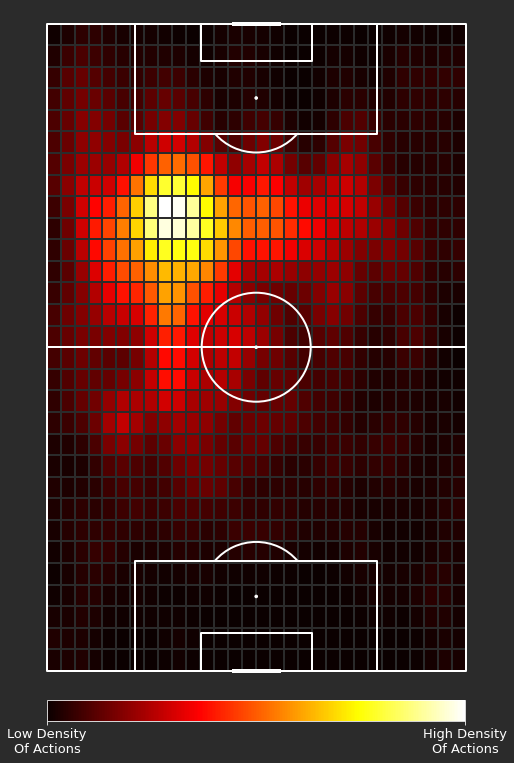

In [20]:
fig, ax = plt.subplots(1,1,figsize=(15,15))

pitch = mplsoccer.VerticalPitch(pitch_type='opta', line_zorder=2,pitch_color='#2b2b2b',line_color='w')
pitch.draw(ax=ax)
fig.set_facecolor('#2b2b2b')
bin_statistic = pitch.bin_statistic(x=carriesPedri['endX'],y=carriesPedri['endY'],statistic='count',bins=(30,30))
bin_statistic['statistic'] = scipy.ndimage.gaussian_filter(bin_statistic['statistic'],1)
pitch_hm = pitch.heatmap(bin_statistic,ax=ax,cmap='hot',edgecolors='#2b2b2b')

cbar = fig.colorbar(pitch_hm,ax=ax,orientation='horizontal',shrink=0.5,pad=0.015)
cbar.outline.set_edgecolor('white')
cbar.ax.xaxis.set_tick_params(color='white',labelsize=13)
cbar.set_ticks([0,bin_statistic['statistic'].max()])
cbar.set_ticklabels(['Low Density\nOf Actions','High Density\nOf Actions'])
plt.setp(plt.getp(cbar.ax.axes, 'xticklabels'), color='white')
# ax.text(1,1,'@barcalytix', ha='right',va='bottom',fontsize=15, color='gray', alpha=0.5, weight='bold')

fig.show()

# Progressive Passes

In [21]:
from sklearn.cluster import KMeans

progPassCoords = np.array(progPasses[['x','y','endX','endY']]) 

kmeans = KMeans(n_clusters=3,random_state=32)
kmeans.fit(progPassCoords)
progPasses['cluster'] = kmeans.predict(progPassCoords)

In [22]:
progPasses['cluster'].value_counts()

0    23
1    19
2    18
Name: cluster, dtype: int64

In [23]:
progPasses.recipientName.value_counts()

Lionel Messi          18
Ousmane Dembélé        8
Antoine Griezmann      8
Sergiño Dest           6
Junior Firpo           4
Frenkie de Jong        4
Jordi Alba             4
Martin Braithwaite     3
Sergio Busquets        2
Gerard Piqué           1
Óscar Mingueza         1
Trincão                1
Name: recipientName, dtype: int64

In [24]:
colors = {0:'#cf0000',1:'#4da3ff',2:'#f5c800'}
progPasses['clusterColor'] = progPasses['cluster'].apply(lambda x:colors[x])

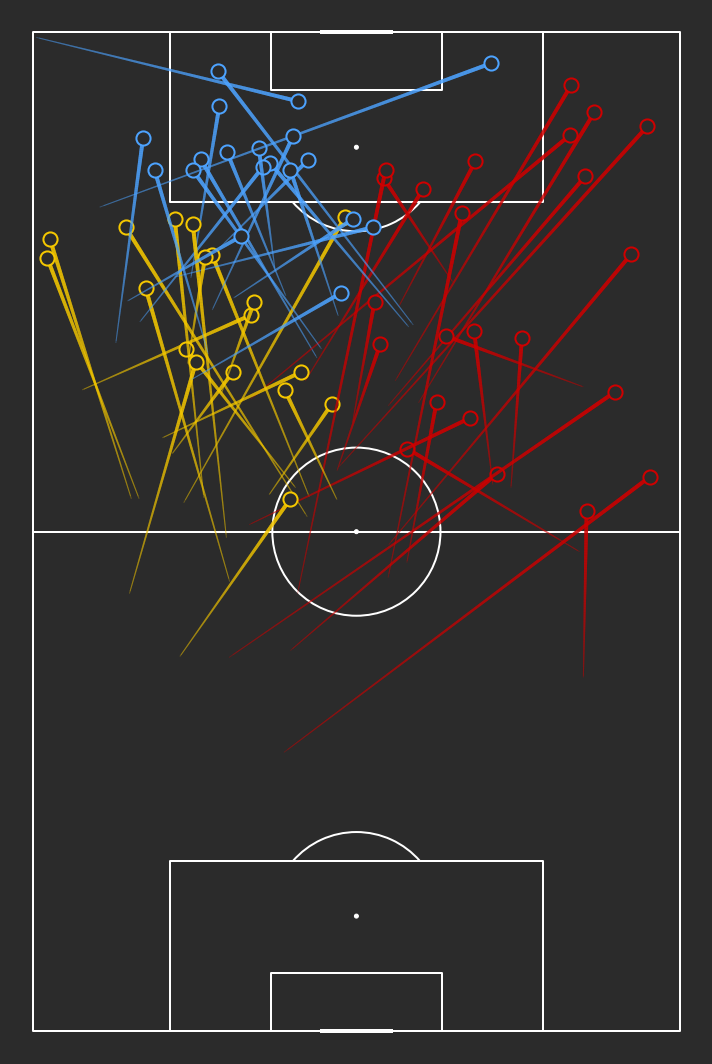

In [25]:
pitch = mplsoccer.VerticalPitch(pitch_type='opta',pitch_color='#2b2b2b',line_color='white') 
fig, ax = pitch.draw(figsize=(10,15)) 
fig.set_facecolor('#2b2b2b')

for index,row in progPasses.iterrows():
    lines = pitch.lines(row.x,row.y,
                        row.endX,row.endY,
                        color=row.clusterColor,
                        comet=True,transparent=True,alpha_end=0.7,alpha_start=0.3,
                        linewidth=4,
                        zorder=1, ax=ax)
    nodes = pitch.scatter(row.endX,row.endY,
                          color='#2b2b2b',edgecolor=row.clusterColor,
                          s=200,linewidth=2,
                          zorder=1,ax=ax)

plt.show()
    

ax.patch.set_facecolor('None')
fig.set_alpha = 0.0
fig.patch.set_visible(False)

fig.savefig(r'D:\Analytics\Football\Trials\Figures\PedriProgPasses.png',dpi=300,bbox_inches='tight')

# xT Combos

In [26]:
events_df

,Unnamed: 0,id,eventId,minute,second,teamId,h_a,x,y,expandedMinute,period,type,outcomeType,qualifiers,satisfiedEventsTypes,isTouch,matchId,startDate,startTime,score,ftScore,htScore,etScore,venueName,maxMinute,playerId,playerName,endX,endY,relatedEventId,relatedPlayerId,blockedX,blockedY,goalMouthZ,goalMouthY,isShot,isGoal,isOwnGoal,cardType,shotBodyType,situation,shotSixYardBox,shotPenaltyArea,shotOboxTotal,shotOpenPlay,shotCounter,shotSetPiece,shotOffTarget,shotOnPost,shotOnTarget,shotsTotal,shotBlocked,shotRightFoot,shotLeftFoot,shotHead,shotObp,goalSixYardBox,goalPenaltyArea,goalObox,goalOpenPlay,goalCounter,goalSetPiece,penaltyScored,goalOwn,goalNormal,goalRightFoot,goalLeftFoot,goalHead,goalObp,shortPassInaccurate,shortPassAccurate,passCorner,passCornerAccurate,passCornerInaccurate,passFreekick,...,goalConcededByTeamDML,goalConcededByTeamDMC,goalConcededByTeamDMR,goalConcededByTeamML,goalConcededByTeamMC,goalConcededByTeamMR,goalConcededByTeamAML,goalConcededByTeamAMC,goalConcededByTeamAMR,goalConcededByTeamFWL,goalConcededByTeamFW,goalConcededByTeamFWR,goalConcededByTeamSub,goalConcededOutsideBoxGoalkeeper,goalScoredByTeamGK,goalScoredByTeamDL,goalScoredByTeamDC,goalScoredByTeamDR,goalScoredByTeamDML,goalScoredByTeamDMC,goalScoredByTeamDMR,goalScoredByTeamML,goalScoredByTeamMC,goalScoredByTeamMR,goalScoredByTeamAML,goalScoredByTeamAMC,goalScoredByTeamAMR,goalScoredByTeamFWL,goalScoredByTeamFW,goalScoredByTeamFWR,goalScoredByTeamSub,aerialSuccess,duelAerialWon,duelAerialLost,offensiveDuel,defensiveDuel,bigChanceMissed,bigChanceScored,bigChanceCreated,overrun,successfulFinalThirdPasses,punches,penaltyShootoutScored,penaltyShootoutMissedOffTarget,penaltyShootoutSaved,penaltyShootoutSavedGK,penaltyShootoutConcededGK,throwIn,subOn,subOff,defensiveThird,midThird,finalThird,pos,started_x,position_x,jerseyNo_x,subId_x,minMinute_x,started_y,position_y,jerseyNo_y,subId_y,minMinute_y,started,position,jerseyNo,subId,minMinute,minsPlayed,recipient,nextTeamId,keyPassEndingCarry,nextAction,recipientName
0,1.0,2.216618e+09,2.0,0.0,0.0,65.0,h,0.0,0.0,0.0,FirstHalf,Start,Successful,[],[],False,1491975.0,2020-09-27T00:00:00,2020-09-27T20:00:00,4 : 0,4 : 0,4 : 0,NaN,Camp Nou,93.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,NaN,False,NaN,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,76202.0,65.0,NaN,NaN,Neto
1,7.0,2.216618e+09,4.0,0.0,21.0,65.0,h,3.6,59.9,0.0,FirstHalf,Pass,Successful,"[{'type': 'Zone', 'value': 'Back'}, {'type': '...","['touches', 'passAccurate', 'shortPassAccurate...",True,1491975.0,2020-09-27T00:00:00,2020-09-27T20:00:00,4 : 0,4 : 0,4 : 0,NaN,Camp Nou,93.0,76202.0,Neto,8.0,67.9,NaN,NaN,NaN,NaN,NaN,NaN,False,False,NaN,False,NaN,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,True,GK,13.0,NaN,NaN,True,GK,13.0,NaN,NaN,True,GK,13.0,NaN,0.0,88.0,236511.0,65.0,NaN,NaN,Clément Lenglet
2,8.0,2.216618e+09,5.0,0.0,25.0,65.0,h,12.2,67.0,0.0,FirstHalf,Pass,Successful,"[{'type': 'StandingSave'}, {'type': 'Pa

In [27]:
def add_xT(df):
    xT = pd.read_csv('xT_grid.csv',header=None)
    xT = np.array(xT)
    xT_rows, xT_cols = xT.shape

    df_copy = df

    df_copy = df_copy[df_copy['x']!=0]
    df_copy = df_copy[df_copy['y']!=0]

    df_copy['x1_bin'] = pd.cut(df_copy['x'],bins=xT_cols,labels=False)
    df_copy['y1_bin'] = pd.cut(df_copy['y'],bins=xT_rows,labels=False)

    df_copy = df_copy[(df_copy['endX'].notna())&(df_copy['endX']!=0.0)]
    df_copy = df_copy[(df_copy['endY'].notna())&(df_copy['endY']!=0.0)]

    df_copy['x2_bin'] = pd.cut(df_copy['endX'],bins=xT_cols,labels=False)
    df_copy['y2_bin'] = pd.cut(df_copy['endY'],bins=xT_rows,labels=False)

    df_copy['start_zone_value'] = df_copy[['x1_bin','y1_bin']].apply(lambda x:xT[x[1],x[0]],axis=1)

    df_copy['end_zone_value'] = df_copy[['x2_bin','y2_bin']].apply(lambda x:xT[x[1],x[0]],axis=1)
    
    df_copy['xT'] = df_copy['end_zone_value'] - df_copy['start_zone_value']
    
    df['xT'] = df_copy['xT']
    
    return df

In [28]:
df = add_xT(events_df)

In [29]:
df['recipientName'].unique()

array(['Neto', 'Clément Lenglet', 'Gerard Piqué', 'Jordi Alba',
       'Ansu Fati', 'Frenkie de Jong', 'Sergi Roberto', 'Sergio Busquets',
       'Antoine Griezmann', 'Philippe Coutinho', 'Lionel Messi', nan,
       'Ousmane Dembélé', 'Pedri', 'Trincão', 'Miralem Pjanic',
       'Ronald Araujo', 'Sergiño Dest', 'Martin Braithwaite',
       'Riqui Puig', 'Marc-André ter Stegen', 'Óscar Mingueza',
       'Junior Firpo', 'Carles Aleñá', 'Samuel Umtiti', 'Ilaix Moriba'],
      dtype=object)

In [30]:
def pedriPassCombos(df):
    passCombo_xT_df = pd.DataFrame()    
    
    pedriPasses = df[(df['type']=='Pass')&(df['outcomeType']=='Successful')&(df['playerName']=='Pedri')]
    pedri_xT_gen = pedriPasses.groupby(['recipientName'])['xT'].sum().reset_index()
    pedri_pass_given = pedriPasses.groupby(['recipientName'])['type'].count().reset_index()
    pedri_xT_gen.rename(columns={'recipientName':'player','xT':'xT Generated'},inplace=True)
    pedri_pass_given.rename(columns={'recipientName':'player','type':'Passes Given'},inplace=True)
    pedri_xT_gen = pedri_xT_gen.merge(pedri_pass_given, how='left', on=['player'])
    
    pedriReception = df[(df['type']=='Pass')&(df['outcomeType']=='Successful')&(df['recipientName']=='Pedri')]
    pedri_xT_rec = pedriReception.groupby(['playerName'])['xT'].sum().reset_index()
    pedri_pass_received = pedriReception.groupby(['playerName'])['type'].count().reset_index()
    pedri_xT_rec.rename(columns={'playerName':'player','xT':'xT Received'},inplace=True)
    pedri_pass_received.rename(columns={'playerName':'player','type':'Passes Received'},inplace=True)
    pedri_xT_rec = pedri_xT_rec.merge(pedri_pass_received, how='left', on=['player'])    
    
    passCombo_xT_df = pd.merge(pedri_xT_gen,pedri_xT_rec,on='player')
    return passCombo_xT_df

In [31]:
x = pedriPassCombos(events_df)

In [32]:
x = x.sort_values(by='Passes Given',ascending = False)
x.reset_index(inplace=True,drop=True)
x = x[0:9]

In [33]:
x['x'] = [35,75,55,42,25,35,75,75,25]
x['y'] = [90,50,30,50,70,10,85,15,30]
x['jerseyNo'] = [18,10,21,5,15,2,7,11,28]

In [34]:
MinMaxScaler = preprocessing.MinMaxScaler(feature_range=(0,1))
x['xT Gen Scaled'] = MinMaxScaler.fit_transform(x['xT Generated'].values.reshape(-1,1))

In [35]:
#Adding linewidth column
x['linewidth'] = ((x['Passes Given']/x['Passes Given'].max()))
#Scaling the linewidth
MIN_LINE_WIDTH = 3
MAX_LINE_WIDTH = 10
MinMaxScaler = preprocessing.MinMaxScaler(feature_range=(MIN_LINE_WIDTH,MAX_LINE_WIDTH))
x['linewidth'] = MinMaxScaler.fit_transform(x['linewidth'].values.reshape(-1,1))

In [36]:
x['midX'] = (55+x['x'])/2
x['midY'] = (70+x['y'])/2

In [37]:
from matplotlib.colors import LinearSegmentedColormap
customcmap2 = LinearSegmentedColormap.from_list('custom cmap', ['#0068ff','#ffffff','#ffffff','#ff0000'])
norm = plt.Normalize(vmin=x['xT Gen Scaled'].min(), vmax=x['xT Gen Scaled'].max())
sm = plt.cm.ScalarMappable(cmap=customcmap2,norm=norm)
colors = customcmap2(norm(x['xT Gen Scaled']))

In [38]:
x

,player,xT Generated,Passes Given,xT Received,Passes Received,x,y,jerseyNo,xT Gen Scaled,linewidth,midX,midY
0,Jordi Alba,-0.084755,290,0.359455,291,35,90,18,0.196462,10.000000,45.0,80.0
1,Lionel Messi,0.800007,235,0.291747,212,75,50,10,1.000000,8.288889,65.0,60.0
2,Frenkie de Jong,-0.116696,146,0.214837,186,55,30,21,0.167453,5.520000,55.0,50.0
3,Sergio Busquets,-0.134912,141,0.248858,151,42,50,5,0.150909,5.364444,48.5,60.0
4,Clément Lenglet,-0.301076,109,0.272652,130,25,70,15,0.000000,4.368889,40.0,70.0
5,Sergiño Dest,0.152792,98,0.153918,103,35,10,2,0.412201,4.026667,45.0,40.0
6,Antoine Griezmann,0.465175,84,-0.081395,105,75,85,7,0.695907,3.591111,65.0,77.5
7,Ousmane Dembélé,0.419811,75,0.435197,81,75,15,11,0.654708,3.311111,65.0,42.5
8,Óscar Mingueza,0.176815,65,0.047043,58,25,30,28,0.434019,3.000000,40.0,50.0


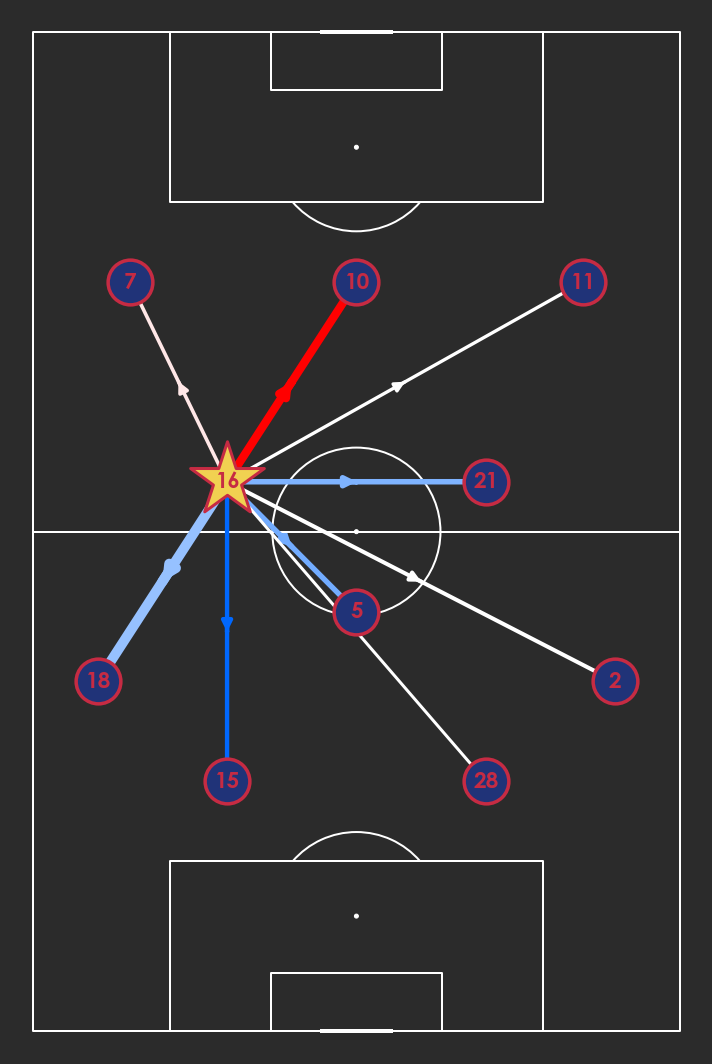

In [39]:
pitch = mplsoccer.VerticalPitch(pitch_type='opta',pitch_color='#2b2b2b',line_color='white',line_zorder=2) 
fig, ax = pitch.draw(figsize=(10,15)) 
fig.set_facecolor('#2b2b2b')



for index,row in x.iterrows():
    lines = pitch.lines(55,70,
                        row.x,row.y,
                        color=colors[index],
                        linewidth=row.linewidth,
                        zorder=3, ax=ax)

nodes = pitch.scatter(x['x'],x['y'],
                      s=2000,
                      color='#203378',edgecolors='#c62b43',
                      linewidth=3.5,alpha=1,
                      zorder=4, ax=ax)

pitch.scatter(55.15,70,
              s=6000,marker='*',
              c='#f1d151',edgecolor='#c62b43',linewidth=3,
              zorder=4,ax=ax) #Pedri

for index, row in x.iterrows():
        pitch.annotate(row['jerseyNo'], xy=(row.x, row.y), 
                       c='#c62b43',
                       va='center', ha='center', 
                       size=22.5, fontweight='bold', fontfamily="Century Gothic",
                       ax=ax,zorder=4)
pitch.annotate('16', xy=(55, 70), 
               c='#c62b43',
               va='center', ha='center', 
               size=22, fontweight='bold', fontfamily="Century Gothic",
               ax=ax,zorder=4)

for index,row in x.iterrows():
        dist = math.dist((row.midY,row.midX),(row.y,row.x))
        ax.annotate("", xytext=(row.midY,row.midX),xy=(row.midY + (0.05/dist)*(row.y - row.midY),
                                                       row.midX + (0.05/dist)*(row.x - row.midX)), 
        arrowprops=dict(arrowstyle="-|>", color=colors[index],lw=row.linewidth), size = 20,zorder=1)
        
# ax.patch.set_facecolor('None')
# fig.set_alpha = 0.0
# fig.patch.set_visible(False)
        
# fig.savefig(r'D:\Analytics\Football\Trials\Figures\PedrixTGiven.png',dpi=300,bbox_inches='tight')